# **Alias-Free Generative Adversarial Networks (StyleGAN3) on Shrimp Images (Healthy, WSSV, BG_WSSV, BG)**

Codes and informations are taken from Official StyleGAN3:https://github.com/NVlabs/stylegan3.git

# 1. Download StyleGan3 Repo

In [1]:
!git clone https://github.com/NVlabs/stylegan3.git

Cloning into 'stylegan3'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 212 (delta 101), reused 96 (delta 96), pack-reused 46 (from 1)
Receiving objects: 100% (212/212), 4.16 MiB | 11.04 MiB/s, done.
Resolving deltas: 100% (107/107), done.


# 2. Convert the Shrimp Dataset (Healthy) to the StyleGAN3 specified dataset

the backslash (\\) is known as a Line Continuation Character.

In [2]:
!python /kaggle/working/stylegan3/dataset_tool.py \
--source=/kaggle/input/elsevier-disease-shrimp-data/Elsevier_ShrimpImages/Elsevier_ShrimpImages/Healthy \
--dest=/kaggle/working/output/elsevier-disease-shrimp-data/Elsevier_ShrimpImages/Elsevier_ShrimpImages_4_StyleGAN3/Healthy.zip \
--resolution=256x256

  0%|                                                   | 0/403 [00:00<?, ?it/s]/kaggle/working/stylegan3/dataset_tool.py:441: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = PIL.Image.fromarray(img, { 1: 'L', 3: 'RGB' }[channels])
100%|█████████████████████████████████████████| 403/403 [00:31<00:00, 12.81it/s]


# 2.1 Update train.py to resolve *ValueError: betas must be either both floats or both Tensors*

In [3]:
!sed -i "s/betas=\[0,0\.99\]/betas=[0.0,0.99]/g" /kaggle/working/stylegan3/train.py

**Make sure to refresh the /kaggle/working folder after updating train.pya**

# 3. Initial Training of StyleGAN3

The result quality and training time depend heavily on the exact set of options. The most important ones (**--gpus, --batch, and --gamma**) must be specified explicitly, and they should be selected with care.

training time also depends on the --kimg and --metric options.

--kimg controls the total number of training iterations and is set to 25000 by default. This is long enough to reach convergence in typical cases, but in practice the results should already look quite reasonable around 5000 kimg.

--metrics determines which quality metrics are computed periodically during training. The default is fid50k_full, which increases the training time slightly; typically by no more than 5%. The automatic computation can be disabled by specifying --metrics=none

In the above example, the total training time on V100 is approximately 18.47 s/kimg * 25000 kimg * 1.05 ≈ 485,000 seconds ≈ 5 days and 14 hours. Disabling metric computation (--metrics=none) reduces this to approximately 5 days and 8 hours.

doubling the resolution (e.g., 256x256 → 512x512) means that --gamma should be multiplied by 4 (e.g., 2 → 8).

--mirror=1 augments the dataset with random x-flips, which effectively doubles the number of images. This is generally beneficial with datasets that are horizontally symmetric (e.g., FFHQ), but it can be harmful if the images contain noticeable asymmetric features (e.g., text or letters).

Specifying --aug=noaug disables adaptive discriminator augmentation (ADA), which may improve the results slightly if the training set is large enough (at least 100k images when accounting for x-flips). With small datasets (less than 30k images), it is generally a good idea to leave the augmentations enabled.

By default, train.py exports network snapshots once every 200 kimg, i.e., the product of --snap=50 and --tick=4. When using few GPUs (e.g., 1–2), this means that it may take a very long time for the first snapshot to appear. We recommend increasing the snapshot frequency in such cases by specifying --snap=20, --snap=10, or --snap=5.

**When using few GPUs (e.g., 1–2), this means that it may take a very long time for the first snapshot to appear. We recommend increasing the snapshot frequency in such cases by specifying --snap=20, --snap=10, or --snap=5.**

stylegan3-t is faster, stylegan3-r provides more diverse images

In [4]:
# !python /kaggle/working/stylegan3/train.py \
#   --outdir=/kaggle/working/stylegan3/training-runs \
#   --cfg=stylegan3-t \
#   --data=/kaggle/working/output/elsevier-disease-shrimp-data/Elsevier_ShrimpImages/Elsevier_ShrimpImages_4_StyleGAN3/Healthy.zip \
#   --gpus=2 \
#   --batch=32 \
#   --mirror=1 \
#   --gamma=2 \
#   --kimg=500 \
#   --snap=10 \
# --metrics=none 

# 3.1 Transfer Learning of the first trained Model

Transfer learning is a machine learning technique where a model developed for one task is reused as the starting point for a second, related task. Instead of training from scratch, it leverages knowledge (features, weights) from a pre-trained model to improve performance, accelerate training, and **reduce the need for large, labeled datasets.**

Transfer learning makes it possible to reach very good results very quickly, especially when the training set is small . To enable transfer learning, you can point --resume to one of the pre-trained

The pre-trained model should be selected to match the specified config(stylegan3-t), resolution, and architecture-related hyperparameters (e.g., --cbase, --map-depth, and --mbstd-group).

With transfer learning, the results may be improved slightly by adjusting --freezed, in addition to the above guidelines for --gamma, --mirror, and --aug. In our experience, --freezed=10 and --freezed=13 tend to work reasonably well.

Example given below, will change based on our training

In [5]:
!python /kaggle/working/stylegan3/train.py --outdir=/kaggle/working/stylegan3/training-runs --cfg=stylegan3-t --data=/kaggle/working/output/elsevier-disease-shrimp-data/Elsevier_ShrimpImages/Elsevier_ShrimpImages_4_StyleGAN3/Healthy.zip \
    --gpus=2 --batch=32 --gamma=2 --mirror=1 --kimg=160 --snap=10 --metrics=none \
    --resume=/kaggle/input/models/arqambinalmas/healthy-shrimp-240-snap/pytorch/default/2/network-snapshot-000100.pkl


Training options:
{
  "G_kwargs": {
    "class_name": "training.networks_stylegan3.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "channel_base": 32768,
    "channel_max": 512,
    "magnitude_ema_beta": 0.9988915792636801
  },
  "D_kwargs": {
    "class_name": "training.networks_stylegan2.Discriminator",
    "block_kwargs": {
      "freeze_layers": 0
    },
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_base": 32768,
    "channel_max": 512
  },
  "G_opt_kwargs": {
    "class_name": "torch.optim.Adam",
    "betas": [
      0.0,
      0.99
    ],
    "eps": 1e-08,
    "lr": 0.0025
  },
  "D_opt_kwargs": {
    "class_name": "torch.optim.Adam",
    "betas": [
      0.0,
      0.99
    ],
    "eps": 1e-08,
    "lr": 0.002
  },
  "loss_kwargs": {
    "class_name": "training.loss.StyleGAN2Loss",
    "r1_gamma": 2.0,
    "blur_init_sigma": 0
  },
  "data_loader_kwargs": {
    "pin_mem

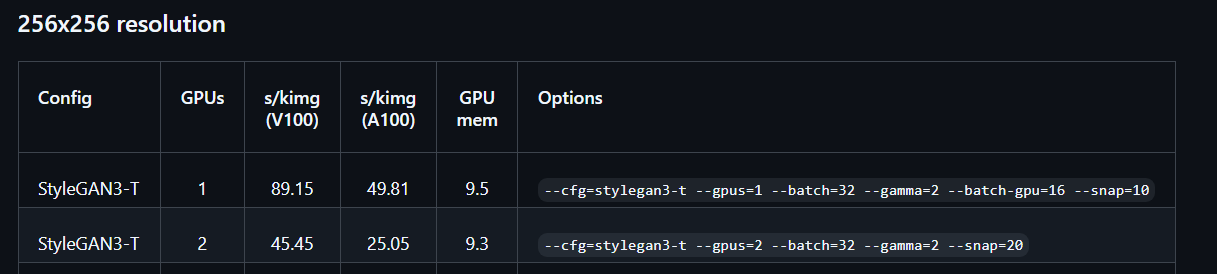

# 4.0 Metric Evaluation

 When desired, the automatic computation can be disabled with --metrics=none to speed up the training slightly.Additional quality metrics can also be computed after the training

*Note that the metrics can be quite expensive to compute (up to 1h), and many of them have an additional one-off cost for each new dataset (up to 30min). Also note that the evaluation is done using a different random seed each time, so the results will vary if the same metric is computed multiple times.*

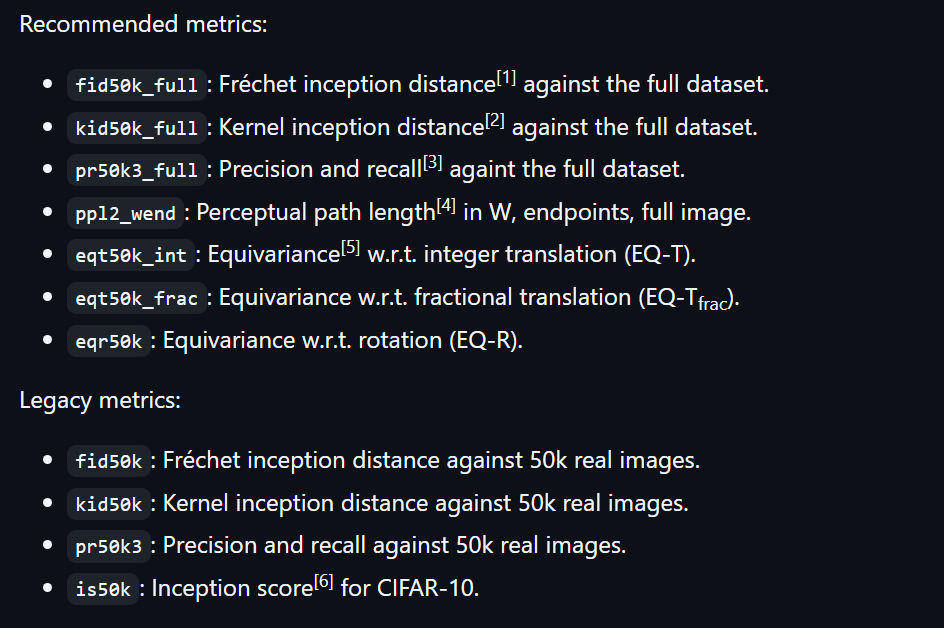

In [6]:
# # Previous training run: look up options automatically, save result to JSONL file.
# !python calc_metrics.py --metrics=eqt50k_int,eqr50k \
#     --network=~/training-runs/00000-stylegan3-r-mydataset/network-snapshot-000000.pkl

> Sprectral Analysis-- Optional

In [7]:
# #Example Code
# # Calculate dataset mean and std, needed in subsequent steps.
# python avg_spectra.py stats --source=~/datasets/ffhq-1024x1024.zip

# # Calculate average spectrum for the training data.
# python avg_spectra.py calc --source=~/datasets/ffhq-1024x1024.zip \
#     --dest=tmp/training-data.npz --mean=112.684 --std=69.509

# # Calculate average spectrum for a pre-trained generator.
# python avg_spectra.py calc \
#     --source=https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl \
#     --dest=tmp/stylegan3-r.npz --mean=112.684 --std=69.509 --num=70000

# # Display results.
# python avg_spectra.py heatmap tmp/training-data.npz
# python avg_spectra.py heatmap tmp/stylegan3-r.npz
# python avg_spectra.py slices tmp/training-data.npz tmp/stylegan3-r.npz

# 5. Generate Image

In [8]:
# !python /kaggle/input/stylegan3-healthy/stylegan3/gen_images.py --outdir=/kaggle/working/gen_images \
# --seeds=0-10 \ 
# --network=/kaggle/input/stylegan3-healthy/stylegan3/training-runs/00000-stylegan3-t-Healthy-gpus2-batch64-gamma2/network-snapshot-000002.pkl

# 6. Zipping the Generated images folder to download

In [9]:
# import shutil
# import os
# from IPython.display import FileLink

# # Define the folder to zip and the output name
# folder_to_zip = '/kaggle/working/gen_images'
# output_filename = 'generated_images_archive'

# # Create the zip file
# shutil.make_archive(output_filename, 'zip', folder_to_zip)

# print(f"Archive created: {output_filename}.zip")